<h1> Approach<h1>

<h3>In order to understand better the patterns of the data, i will make use of libraries like matplotlib and seaborn to deep dive cases in the dataset and give better visibility on what is happening with the different types of Rossman drug stores.<h3>

In [2]:
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
import dvc

In [3]:
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

In [4]:
# changing string to date
def str_to_date(date):
      return datetime.strptime(date, '%Y-%m-%d').date()

<h3> Load the datasets <h3>

In [5]:
# reading a dataframe
df_train = pd.read_csv("../data/train.csv",sep=',', parse_dates=['Date'], date_parser=str_to_date,
low_memory = False)

In [6]:
#Additional Information on those stores 
df_store = pd.read_csv('../data/store.csv', low_memory = False)

In [18]:
# reading the test data
df_test = pd.read_csv("../data/test.csv",sep=',', parse_dates=['Date'], date_parser=str_to_date,
low_memory = False)

<h3>A quick view at the data on hand<h3>

In [7]:
df_train.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
df_train.dtypes,print (f'The Train dataset has {str(df_train.shape[0])} Rows and {str(df_train.shape[1])} Variables')

The Train dataset has 1017209 Rows and 9 Variables


(Store                     int64
 DayOfWeek                 int64
 Date             datetime64[ns]
 Sales                     int64
 Customers                 int64
 Open                      int64
 Promo                     int64
 StateHoliday             object
 SchoolHoliday             int64
 dtype: object,
 None)

<h3>Calculating how many missing fields each variable has<h3>

In [10]:
df_train.count(0)/df_train.shape[0] * 100

Store           100.000000
DayOfWeek       100.000000
Date            100.000000
Sales           100.000000
Customers       100.000000
Open            100.000000
Promo           100.000000
StateHoliday    100.000000
SchoolHoliday   100.000000
dtype: float64

### no missing value found on train data set but a closer look at the Train set is needed


### let us see Stores Closed (which means 0 customers and 0 sales) on Certain days:

In [41]:
print ()
print (f"-Over those two years, {df_train[(df_train.Open == 0)].count()[0]} is the number of times that different stores closed on given days.")
print ()
print (f"-From those closed events, {df_train[(df_train.Open == 0) & (df_train.SchoolHoliday == 1)&(df_train.StateHoliday == '0') ].count()[0]} times occured because there was a school holiday. ")
print ()
print ("-And {} times it occured because of either a bank holiday or easter or christmas.".format(df_train[(df_train.Open == 0) &
         ((df_train.StateHoliday == 'a') |
          (df_train.StateHoliday == 'b') | 
          (df_train.StateHoliday == 'c'))].count()[0]))
print ()
print ("-But interestingly enough, {} times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.".format(df_train[(df_train.Open == 0) &
         (df_train.StateHoliday == "0")
         &(df_train.SchoolHoliday == 0)].count()[0]))
print ()


-Over those two years, 172817 is the number of times that different stores closed on given days.

-From those closed events, 3067 times occured because there was a school holiday. 

-And 30140 times it occured because of either a bank holiday or easter or christmas.

-But interestingly enough, 139610 times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.



### since we don't want to bias our models to consider those exceptions, the best solution here is to get rid of closed stores and prevent the models to train on them and get false guidance.

### In this case we will analyse only open stores since a close store yield a profit of 0.

In [42]:
df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)

In [43]:
df_train = df_train.reset_index(drop=True)

In [45]:
train_path = ('../data/train.csv')

In [47]:
df_train.to_csv(train_path, index= False)

In [49]:
print ("Our new training set has now {} rows ".format(df_train.shape[0]))

Our new training set has now 844392 rows 


In [11]:
df_store.head() 

,Store,StoreType,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
1,2,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN


In [21]:
df_store.dtypes,print (f'The Store dataset has {str(df_store.shape[0])} Rows and {str(df_store.shape[1])} Variables')

The Store dataset has 1115 Rows and 9 Variables


(Store                          int64
 StoreType                     object
 CompetitionDistance          float64
 CompetitionOpenSinceMonth    float64
 CompetitionOpenSinceYear     float64
 Promo2                         int64
 Promo2SinceWeek              float64
 Promo2SinceYear              float64
 PromoInterval                 object
 dtype: object,
 None)

In [19]:
# calculating missing values
df_store.isnull().sum()

Store                          0
StoreType                      0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

<h2>There are many missing values found on store data on some of the columns<h2>

In [40]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.000000,1,0,0
1,2,3,4,2015-09-17,1.000000,1,0,0
2,3,7,4,2015-09-17,1.000000,1,0,0
3,4,8,4,2015-09-17,1.000000,1,0,0
4,5,9,4,2015-09-17,1.000000,1,0,0


In [22]:
df_train.dtypes,print (f'The test dataset has {str(df_test.shape[0])} Rows and {str(df_test.shape[1])} Variables')

The test dataset has 41088 Rows and 8 Variables


(Store                     int64
 DayOfWeek                 int64
 Date             datetime64[ns]
 Sales                     int64
 Customers                 int64
 Open                      int64
 Promo                     int64
 StateHoliday             object
 SchoolHoliday             int64
 dtype: object,
 None)

In [23]:
# calculating missing values
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

### only open column has missing values

# Plotting  distribution of promotion in both training and test sets 

Text(0.5, 1.0, 'Promotion histogram')

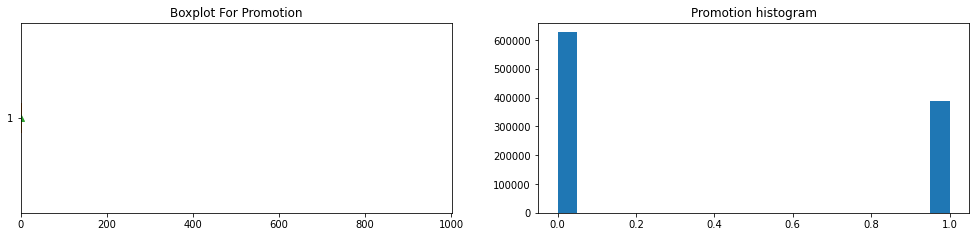

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_train.Promo, showmeans=True,vert=False)
axes[0].set_xlim(0,max(df_train["Promo"]+1000))
axes[0].set_title('Boxplot For Promotion')
axes[1].hist(df_train.Promo, cumulative=False, bins=20)
axes[1].set_title("Promotion histogram")


Text(0.5, 1.0, 'Promotion histogram')

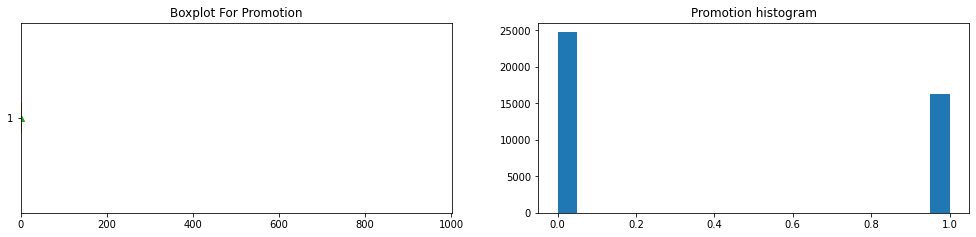

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_test.Promo, showmeans=True,vert=False)
axes[0].set_xlim(0,max(df_test["Promo"]+1000))
axes[0].set_title('Boxplot For Promotion')
axes[1].hist(df_test.Promo, cumulative=False, bins=20)
axes[1].set_title("Promotion histogram")

In [28]:
def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str) -> None:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)

In [33]:
def plot_dist(df:pd.DataFrame, column:str):
    plt.figure(figsize=(9,7))
    sns.distplot(df).set_title(f'Distribution of {column}')

TypeError: float() argument must be a string or a number, not 'Timestamp'

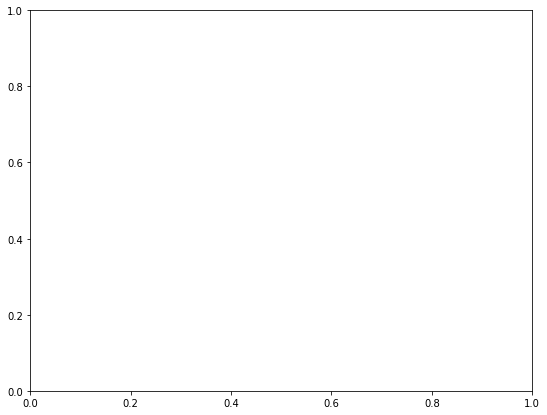

In [34]:
plot_dist(df_train,'Promo')

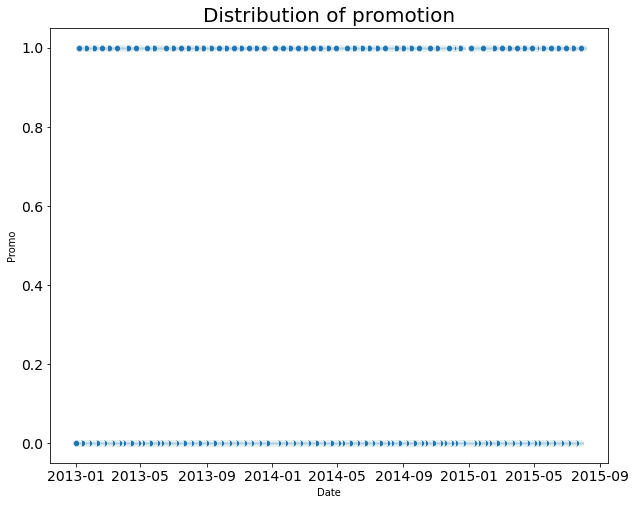

In [30]:
plot_scatter(df_train,'Date','Promo','Distribution of promotion')

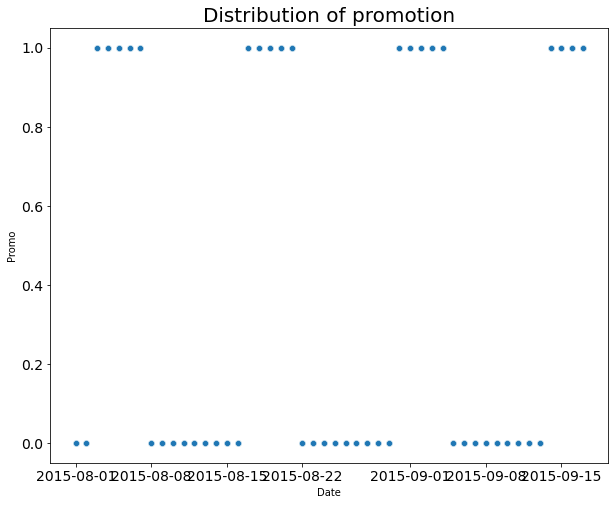

In [31]:
plot_scatter(df_test,'Date','Promo','Distribution of promotion')